In [1]:
#write scores into test sets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from minicons import scorer
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir('/home/qy2672/learning-alternations')

def safe_score_sequence(text, lm, tokenizer):
    try:
        device = next(lm.model.parameters()).device
        
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=256,
            padding=True
        ).to(device)  

        return lm.sequence_score(inputs)[0]
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return float('nan')
    
models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']
dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

for model_name in models:
    model_path = 'qing-yao/'+model_name+'_seed-42_1e-3'

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float32,
        device_map="auto"
    )

    lm = scorer.IncrementalLMScorer(
        model=model,
        device="auto",
        tokenizer=tokenizer
    )
    dos['do' + model_name] = dos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos['po' + model_name] = dos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos[model_name + '_ratio'] = dos['do'+model_name] - dos['po'+model_name]
    dos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    dos.to_csv('experiments/do_datives.csv', index = False)
    pos['do' + model_name] = pos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos['po' + model_name] = pos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos[model_name + '_ratio'] = pos['do'+model_name] - pos['po'+model_name]
    pos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    pos.to_csv('experiments/po_datives.csv', index = False)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

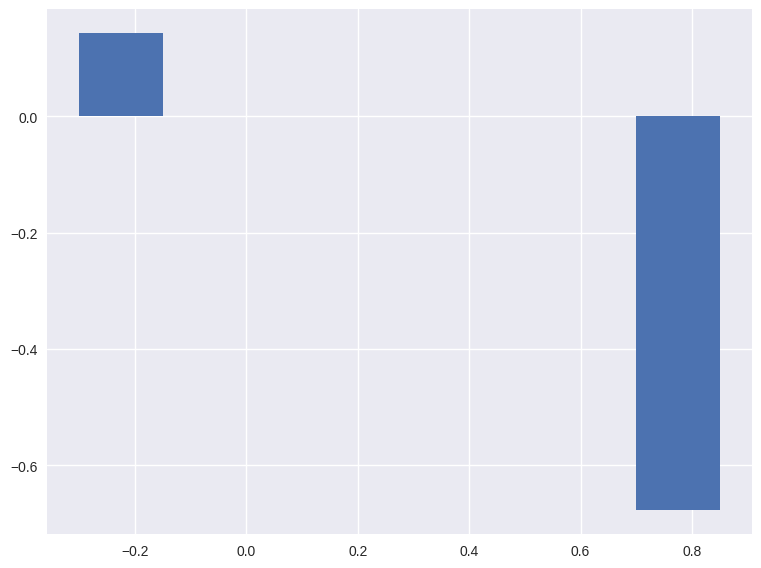

In [9]:
import os
os.chdir('/home/qy2672/learning-alternations')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

def prepare_data(dos, pos, model_name):
    """Prepare data for visualization by combining DO and PO dataframes"""
    # Add construction type and combine
    dos['Construction'] = 'DO'
    pos['Construction'] = 'PO'
    combined = pd.concat([dos, pos])
    
    # Add score column
    combined[f'{model_name}_score'] = combined[f'{model_name}_ratio']
    
    return combined

def create_visualization_suite(dos, pos, models=['babylm-default', 'babylm-balanced']):
    # Set style
    plt.style.use('seaborn-v0_8')
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 2)
    
    # Color scheme
    colors = {'DO': '#3498db', 'PO': '#e67e22'}
    
    # 1. Model Comparison Plot (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    for i, model in enumerate(models):
        data = prepare_data(dos, pos, model)
        # Ensure we get mean scores for each combination of recipient_pos and Construction
        model_means = data.groupby(['recipient_pos', 'Construction'])[f'{model}_score'].mean().reset_index()
        
        # Reshape data to ensure consistent ordering
        pron_data = []
        nonpron_data = []
        for const in ['DO', 'PO']:
            pron_val = model_means[(model_means['recipient_pos'] == 'PRON') & 
                                 (model_means['Construction'] == const)][f'{model}_score'].values
            nonpron_val = model_means[(model_means['recipient_pos'] != 'PRON') & 
                                    (model_means['Construction'] == const)][f'{model}_score'].values
            pron_data.extend(pron_val)
            nonpron_data.extend(nonpron_val)
        
        # Plot bars with consistent shapes
        x = np.arange(2)  # [0, 1] for DO and PO
        width = 0.15
        
        ax1.bar(x - width*1.5 + i*width, pron_data,
                width, label=f'{model} (Pronoun)')
        ax1.bar(x + width*1.5 + i*width, nonpron_data,
                width, label=f'{model} (Non-Pronoun)')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(['DO', 'PO'])
    ax1.set_title('Model Comparison: Pronoun vs Non-Pronoun')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_ylabel('Score')
    
    # 2. Length Effect Heat Map (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    data = prepare_data(dos, pos, models[0])  # Using first model for example
    pivot_data = pd.pivot_table(
        data=data,
        values=f'{models[0]}_score',
        index='len_category',
        columns=['Construction', 'recipient_pos'],
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, cmap='RdBu_r', center=0,
                ax=ax2, fmt='.2f', cbar_kws={'label': 'Score'})
    ax2.set_title('Length Effect by Construction and Pronoun Status')
    
    # 3. Pronoun Effect Plot (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    for model in models:
        data = prepare_data(dos, pos, model)
        sns.boxplot(data=data, x='recipient_pos', y=f'{model}_score',
                   hue='Construction', palette=colors,
                   ax=ax3, showfliers=False)
    ax3.set_title('Pronoun Effect on Scores')
    ax3.set_xlabel('Recipient Type')
    ax3.set_ylabel('Score')
    
    # 4. Length Trend Plot (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    for model in models:
        data = prepare_data(dos, pos, model)
        for const in ['DO', 'PO']:
            subset = data[data['Construction'] == const]
            means = subset.groupby('len_category')[f'{model}_score'].mean()
            x_vals = range(len(means))
            ax4.plot(x_vals, means.values, 
                    label=f'{model} {const}',
                    color=colors[const],
                    linestyle='-' if model == models[0] else '--',
                    marker='o')
    
    ax4.set_xticks(range(3))
    ax4.set_xticklabels(['Recipient Shorter', 'Equal Length', 'Recipient Longer'])
    ax4.set_title('Length Effect Trends')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.set_ylabel('Score')
    
    plt.tight_layout()
    return fig

# Example usage:
dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')
fig = create_visualization_suite(dos, pos)
plt.show()

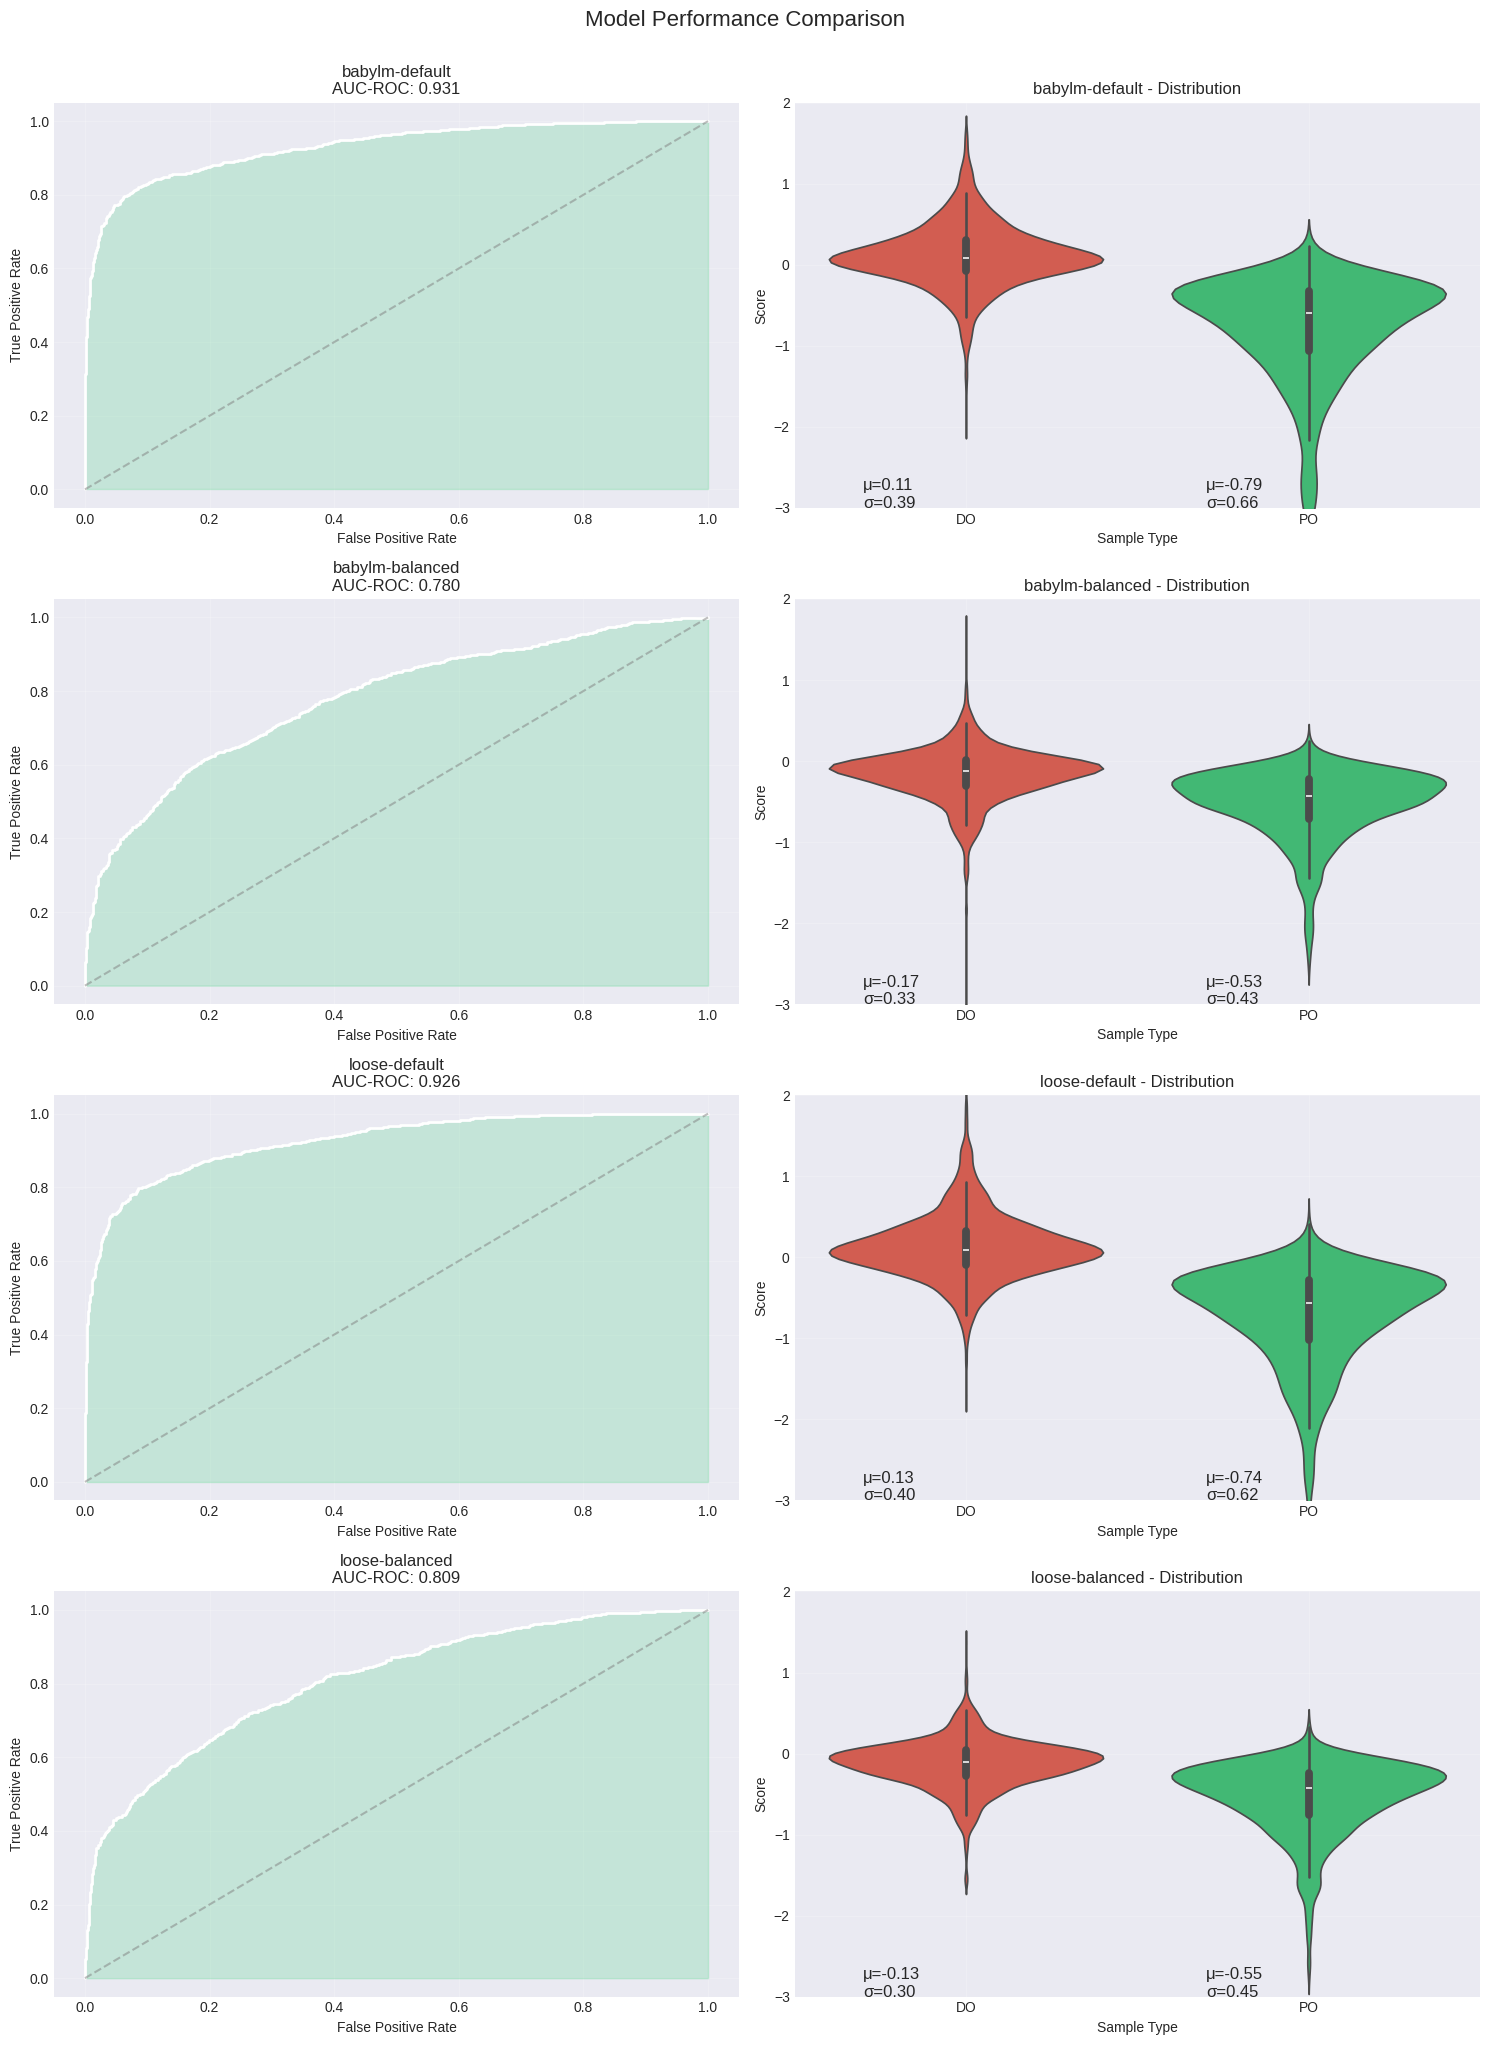

In [1]:
#model prediction on datives, compare distributions
import pandas as pd
import os 

os.chdir('/home/qy2672/learning-alternations')
pos = pd.read_csv('experiments/po_datives.csv')
dos = pd.read_csv('experiments/do_datives.csv')

models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score


plt.style.use('seaborn-v0_8-dark')
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

po_color = '#2ecc71'  # green
do_color = '#e74c3c'  # red
po_color_dark = '#27ae60'  # darker green for swarm
do_color_dark = '#c0392b'  # darker red for swarm

def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(x1) - np.mean(x2)) / pooled_se

def distribution_overlap(x1, x2, bins=100):
    min_val = min(np.min(x1), np.min(x2))
    max_val = max(np.max(x1), np.max(x2))
    hist1, bins = np.histogram(x1, bins=bins, range=(min_val, max_val), density=True)
    hist2, _ = np.histogram(x2, bins=bins, range=(min_val, max_val), density=True)
    return np.sum(np.minimum(hist1, hist2)) * (bins[1] - bins[0])

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx, 0]
    # ax_combined = axes[idx, 1]
    ax_violin = axes[idx, 1]  
    
    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    
    # Calculate statistics
    cd = cohens_d(do_scores, po_scores)
    true_labels = [1] * len(do_scores) + [0] * len(po_scores)
    scores = np.concatenate([do_scores, po_scores])
    auc_score = roc_auc_score(true_labels, scores)
    ap_score = average_precision_score(true_labels, scores)
    overlap = distribution_overlap(do_scores, po_scores)
    
    # 1. ROC Curve 
    fpr, tpr, _ = roc_curve(true_labels, scores)
    ax_scatter.plot(fpr, tpr, color='white', linewidth=2)
    ax_scatter.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
    ax_scatter.fill_between(fpr, tpr, alpha=0.2, color=po_color)
    ax_scatter.set_xlabel('False Positive Rate')
    ax_scatter.set_ylabel('True Positive Rate')
    ax_scatter.set_title(f'{model_name}\nAUC-ROC: {auc_score:.3f}')
    
    # 2. violin plot
    data = {
        'Score': np.concatenate([do_scores, po_scores]),
        'Sample Type': ['DO'] * len(do_scores) + ['PO'] * len(po_scores)
    }
    # Violin plot with box inside
    sns.violinplot(data=data, x='Sample Type', y='Score', 
                  inner='box', palette={'DO': do_color, 'PO': po_color}, hue = 'Sample Type',
                  ax=ax_violin)
    ax_violin.set_ylim(-3,2)

    # Add mean and std annotations to violin plot
    for i, (label, color) in enumerate([('DO', do_color), ('PO', po_color)]):
        scores = do_scores if label == 'DO' else po_scores
        ax_violin.text(i - 0.3, ax_violin.get_ylim()[0], 
              f'μ={np.mean(scores):.2f}\nσ={np.std(scores):.2f}',
              fontsize=12)
    
    ax_violin.set_title(f'{model_name} - Distribution')

# Adjust layout and styling
plt.tight_layout()
for ax in axes.flat:
    ax.grid(True, alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Model Performance Comparison', y=1.02, fontsize=16)

plt.show()

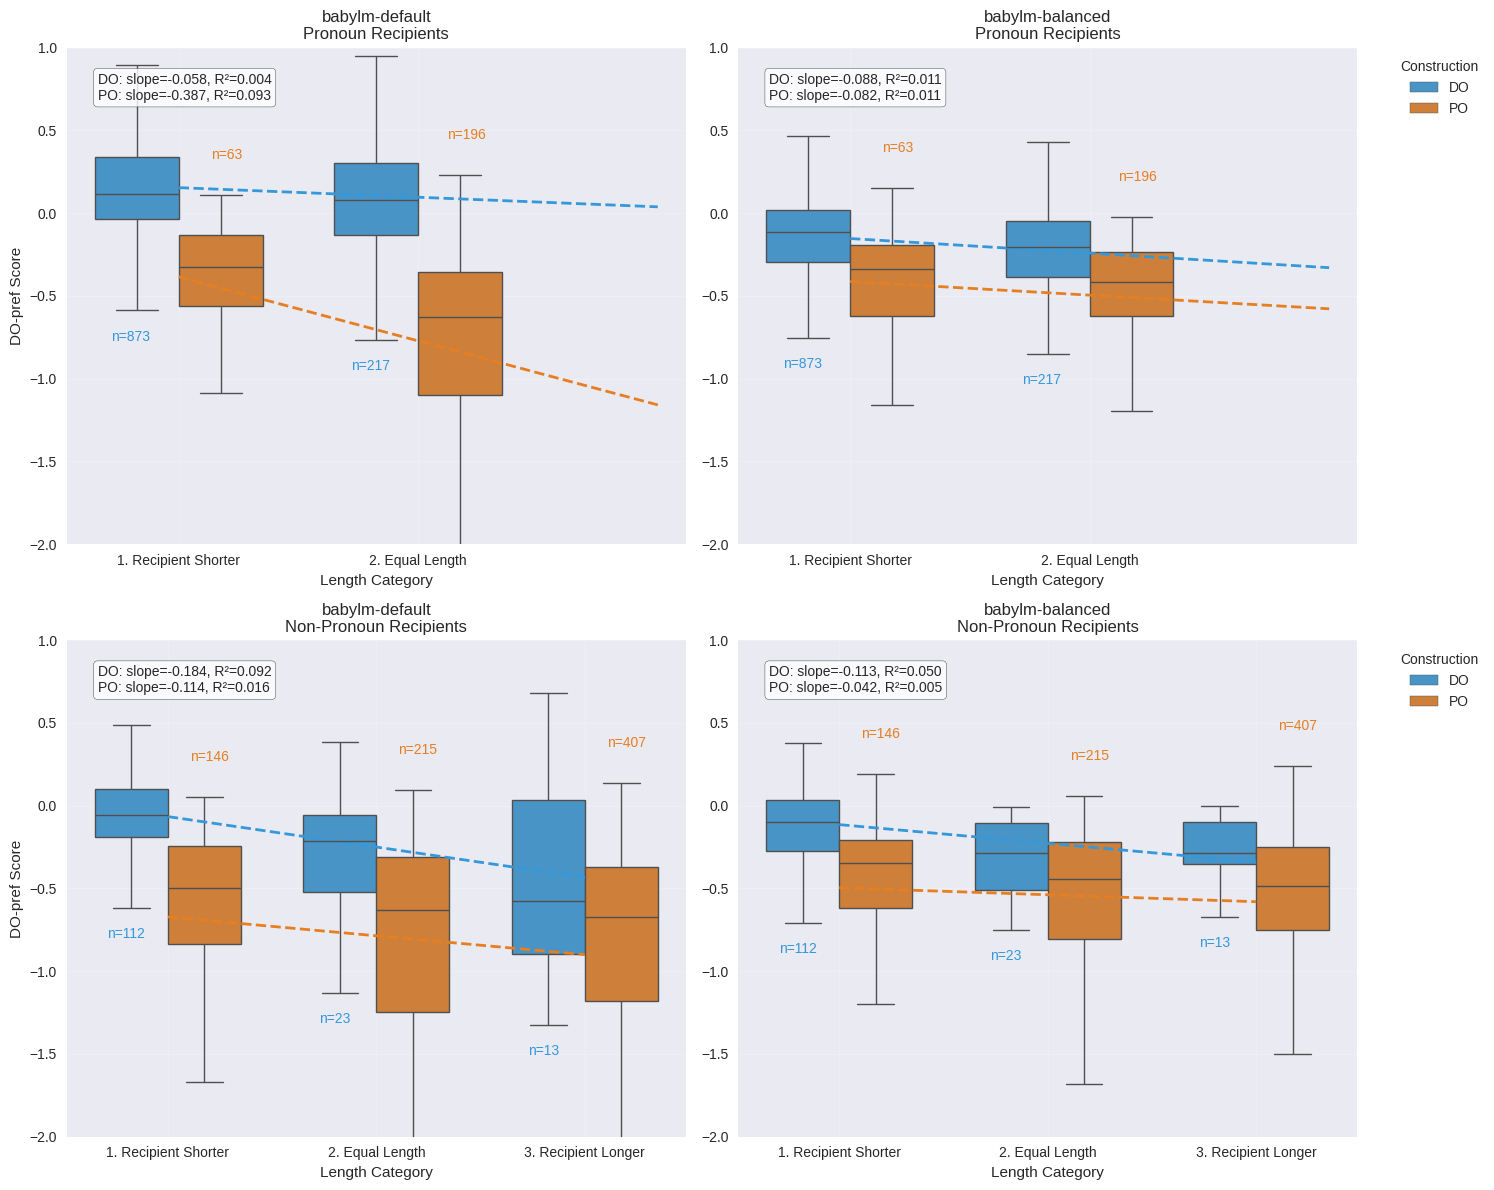


Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length
Construction                                     
DO                       0.207035       -0.620885
PO                      -1.512218        1.305578

Contingency Table (Counts):
len_category  1. Recipient Shorter  2. Equal Length
Construction                                       
DO                             873              217
PO                              63              196

Chi-square statistic: 303.769
p-value: 4.972e-68

Non-Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length 3. Recipient Longer
Construction                                                         
DO                       1.425878       -0.741505           -2.384055
PO                      -0.567161        0.107616            0.208881



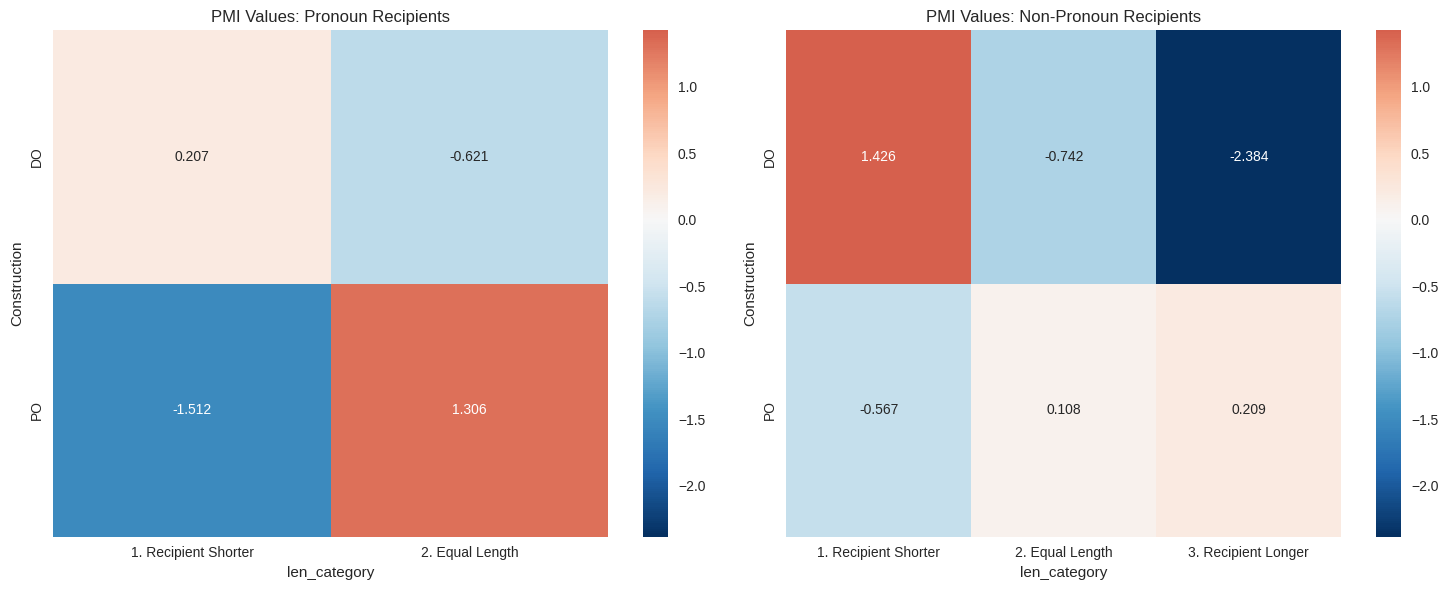

In [2]:
#cluster when sorted by length 
import pandas as pd
import os 

os.chdir('/home/qy2672/learning-alternations')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

dos_p = dos[dos['recipient_pos'] == 'PRON']
pos_p = pos[pos['recipient_pos'] == 'PRON']
dos_notp = dos[dos['recipient_pos'] != 'PRON']
pos_notp = pos[pos['recipient_pos'] != 'PRON']

models = ['babylm-default', 'babylm-balanced', 'removed']
def add_length_category(df):
    df = df.copy()
    df['rec_len'] = df['recipient'].str.split().str.len()
    df['theme_len'] = df['theme'].str.split().str.len()
    df['len_category'] = np.where(df['rec_len'] < df['theme_len'], '1. Recipient Shorter',
                                np.where(df['rec_len'] == df['theme_len'], '2. Equal Length',
                                        '3. Recipient Longer'))
    return df

# Process dataframes
dos_p = add_length_category(dos_p)
pos_p = add_length_category(pos_p)
dos_notp = add_length_category(dos_notp)
pos_notp = add_length_category(pos_notp)

def calculate_fit_stats(df, construction):
    # Convert length categories to numeric values for fitting
    category_map = {
        '1. Recipient Shorter': 0,
        '2. Equal Length': 1,
        '3. Recipient Longer': 2
    }
    x = df[df['Construction'] == construction]['Length Category'].map(category_map)
    y = df[df['Construction'] == construction]['Score']
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2, p_value

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

do_color = '#3498db'
po_color = '#e67e22'

plot_configs = [
    (0, 0, dos_p, pos_p, 'babylm-default', 'Pronoun Recipients'),
    (0, 1, dos_p, pos_p, 'babylm-balanced', 'Pronoun Recipients'),
    (1, 0, dos_notp, pos_notp, 'babylm-default', 'Non-Pronoun Recipients'),
    (1, 1, dos_notp, pos_notp, 'babylm-balanced', 'Non-Pronoun Recipients'),
]

for row, col, do_df, po_df, model_name, title in plot_configs:
    ax = axes[row, col]
    
    box_data = {
        'Score': np.concatenate([do_df[model_name + '_ratio'], 
                               po_df[model_name + '_ratio']]),
        'Construction': ['DO'] * len(do_df) + ['PO'] * len(po_df),
        'Length Category': np.concatenate([do_df['len_category'], 
                                        po_df['len_category']])
    }
    df_plot = pd.DataFrame(box_data)
    
    sns.boxplot(data=df_plot, x='Length Category', y='Score', 
               hue='Construction', 
               palette={'DO': do_color, 'PO': po_color},
               width=0.7, showfliers=False, ax=ax)
    
    for i, category in enumerate(df_plot['Length Category'].unique()):
        for j, construction in enumerate(['DO', 'PO']):
            # Get the subset of data for this category and construction
            subset = df_plot[(df_plot['Length Category'] == category) & 
                            (df_plot['Construction'] == construction)]
            count = len(subset)
            
            Q1 = subset['Score'].quantile(0.25)
            Q3 = subset['Score'].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            lower_bound = Q1 - 1.5 * IQR
            
            non_outlier_min = subset[subset['Score'] >= lower_bound]['Score'].min()
            non_outlier_max = subset[subset['Score'] >= lower_bound]['Score'].max()
            x_pos = i - 0.2 + (j * 0.4)
            y_pos = non_outlier_min - 0.2 if construction == 'DO' else non_outlier_max + 0.2
            
            # Add the count annotation
            ax.text(x_pos, y_pos, f'n={count}', 
                ha='center', va='bottom',
                color=do_color if construction == 'DO' else po_color)
    
    # Calculate and plot linear fits
    x_fit = np.array([0, 1, 2])  # Numeric values for categories
    
    # DO fit
    do_slope, do_intercept, do_r2, do_p = calculate_fit_stats(df_plot, 'DO')
    y_fit_do = do_slope * x_fit + do_intercept
    ax.plot(x_fit, y_fit_do, '--', color=do_color, linewidth=2)
    
    # PO fit
    po_slope, po_intercept, po_r2, po_p = calculate_fit_stats(df_plot, 'PO')
    y_fit_po = po_slope * x_fit + po_intercept
    ax.plot(x_fit, y_fit_po, '--', color=po_color, linewidth=2)
    
    # Add statistical annotations
    fit_stats_text = (f'DO: slope={do_slope:.3f}, R²={do_r2:.3f}\n'
                     f'PO: slope={po_slope:.3f}, R²={po_r2:.3f}')
    ax.text(0.05, 0.95, fit_stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_title(f'{model_name}\n{title}')
    ax.set_xlabel('Length Category')
    ax.set_ylabel('DO-pref Score' if col == 0 else '')
    ax.grid(True, alpha=0.2)
    ax.set_ylim(-2, 1)
    
    if col == 1:
        ax.legend(title='Construction', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend().remove()

plt.tight_layout()
plt.show()


from scipy.stats import chi2_contingency

def calculate_pmi(joint_prob, prob_x, prob_y):
    """Calculate PMI given probabilities"""
    return np.log2(joint_prob / (prob_x * prob_y))

def calculate_pmi_table(df_do, df_po):
    """Calculate PMI between construction type and length categories"""
    # Combine data
    do_data = df_do.copy()
    po_data = df_po.copy()
    do_data['Construction'] = 'DO'
    po_data['Construction'] = 'PO'
    combined = pd.concat([do_data, po_data])
    
    # Create contingency table
    contingency = pd.crosstab(combined['Construction'], 
                             combined['len_category'])
    
    # Calculate probabilities
    total = contingency.sum().sum()
    prob_construction = contingency.sum(axis=1) / total
    prob_length = contingency.sum(axis=0) / total
    
    # Calculate PMI for each cell
    pmi_values = pd.DataFrame(index=contingency.index, 
                            columns=contingency.columns)
    
    for const in contingency.index:
        for length in contingency.columns:
            joint_prob = contingency.loc[const, length] / total
            pmi_values.loc[const, length] = calculate_pmi(
                joint_prob,
                prob_construction[const],
                prob_length[length]
            )
    
    # Calculate chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    return pmi_values, chi2, p_value, contingency

# Calculate PMI for pronoun cases
pmi_pron, chi2_pron, p_pron, cont_pron = calculate_pmi_table(dos_p, pos_p)
# Calculate PMI for non-pronoun cases
pmi_nonpron, chi2_nonpron, p_nonpron, cont_nonpron = calculate_pmi_table(dos_notp, pos_notp)

# Create formatted output tables
def format_table(pmi_values, contingency, chi2, p_value, title):
    print(f"\n{title}")
    print("-" * 80)
    print("\nPMI Values:")
    print(pmi_values.round(3))
    print("\nContingency Table (Counts):")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.3f}")
    print(f"p-value: {p_value:.3e}")

# Display results
format_table(pmi_pron, cont_pron, chi2_pron, p_pron, "Pronoun Recipients")
format_table(pmi_nonpron, cont_nonpron, chi2_nonpron, p_nonpron, "Non-Pronoun Recipients")

# Visualize PMI values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot PMI heatmaps
vmin = min(pmi_pron.values.min(), pmi_nonpron.values.min())
vmax = max(pmi_pron.values.max(), pmi_nonpron.values.max())

sns.heatmap(pmi_pron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('PMI Values: Pronoun Recipients')

sns.heatmap(pmi_nonpron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('PMI Values: Non-Pronoun Recipients')

plt.tight_layout()
plt.show()

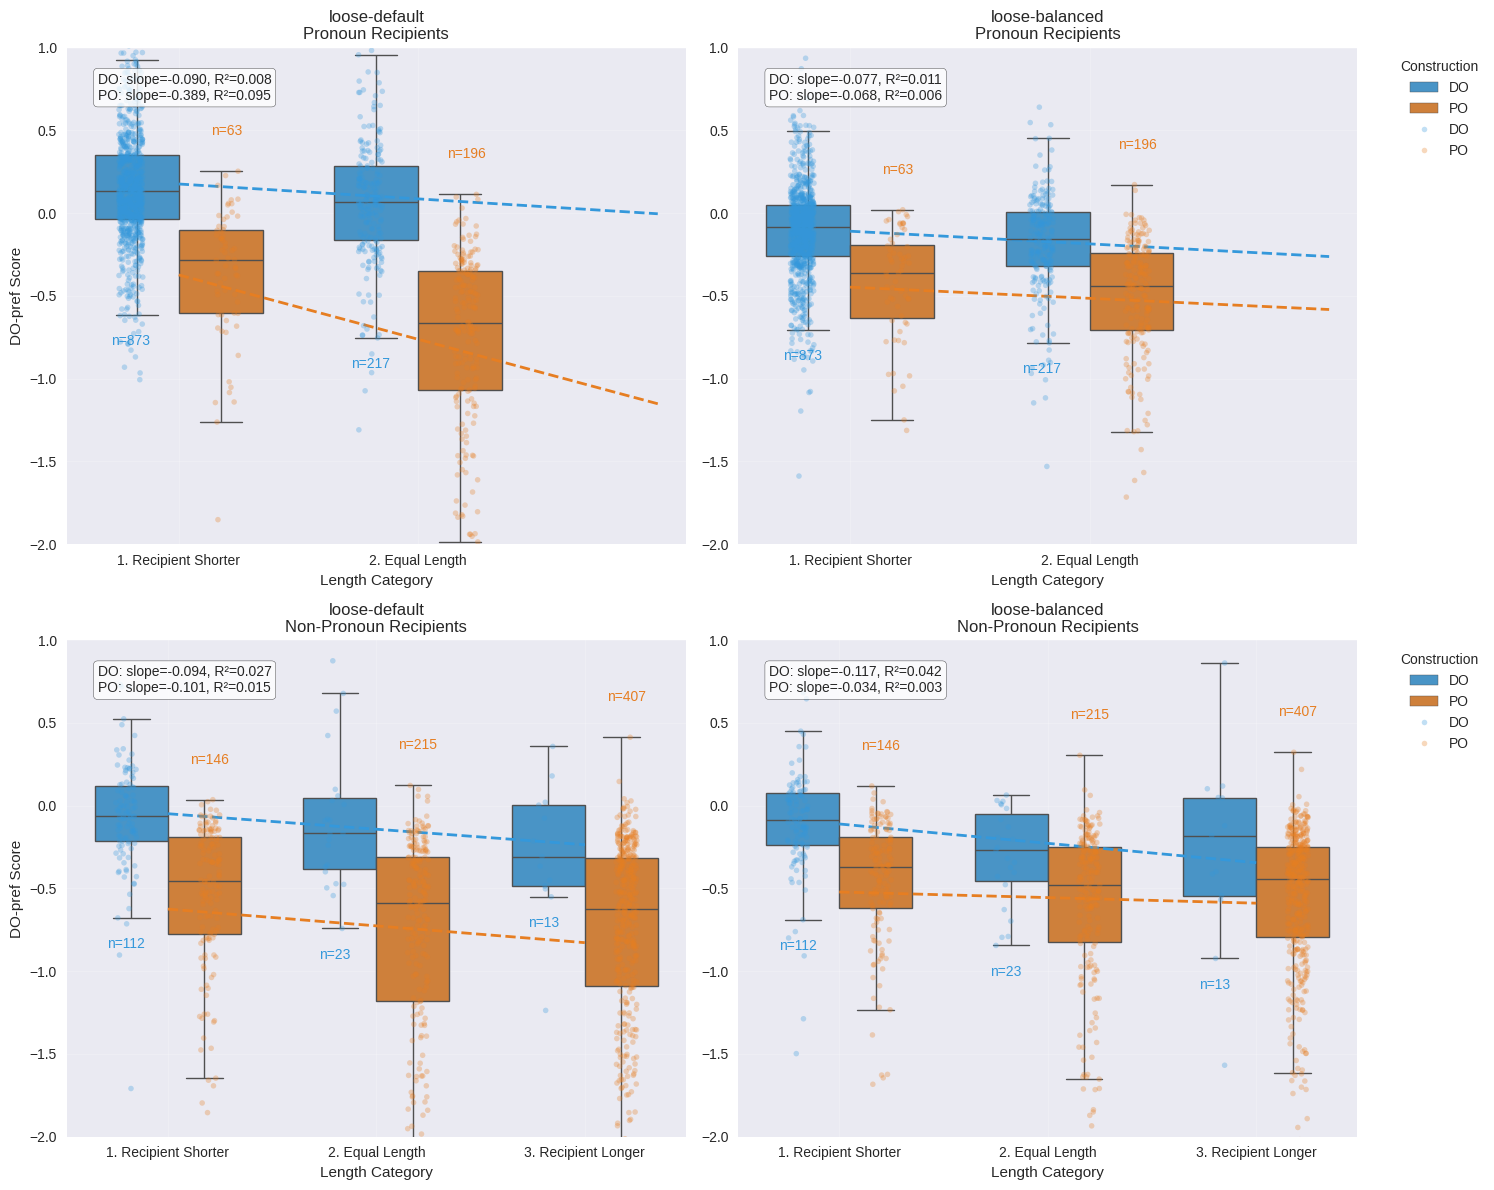


Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length
Construction                                     
DO                       0.207035       -0.620885
PO                      -1.512218        1.305578

Contingency Table (Counts):
len_category  1. Recipient Shorter  2. Equal Length
Construction                                       
DO                             873              217
PO                              63              196

Chi-square statistic: 303.769
p-value: 4.972e-68

Non-Pronoun Recipients
--------------------------------------------------------------------------------

PMI Values:
len_category 1. Recipient Shorter 2. Equal Length 3. Recipient Longer
Construction                                                         
DO                       1.425878       -0.741505           -2.384055
PO                      -0.567161        0.107616            0.208881



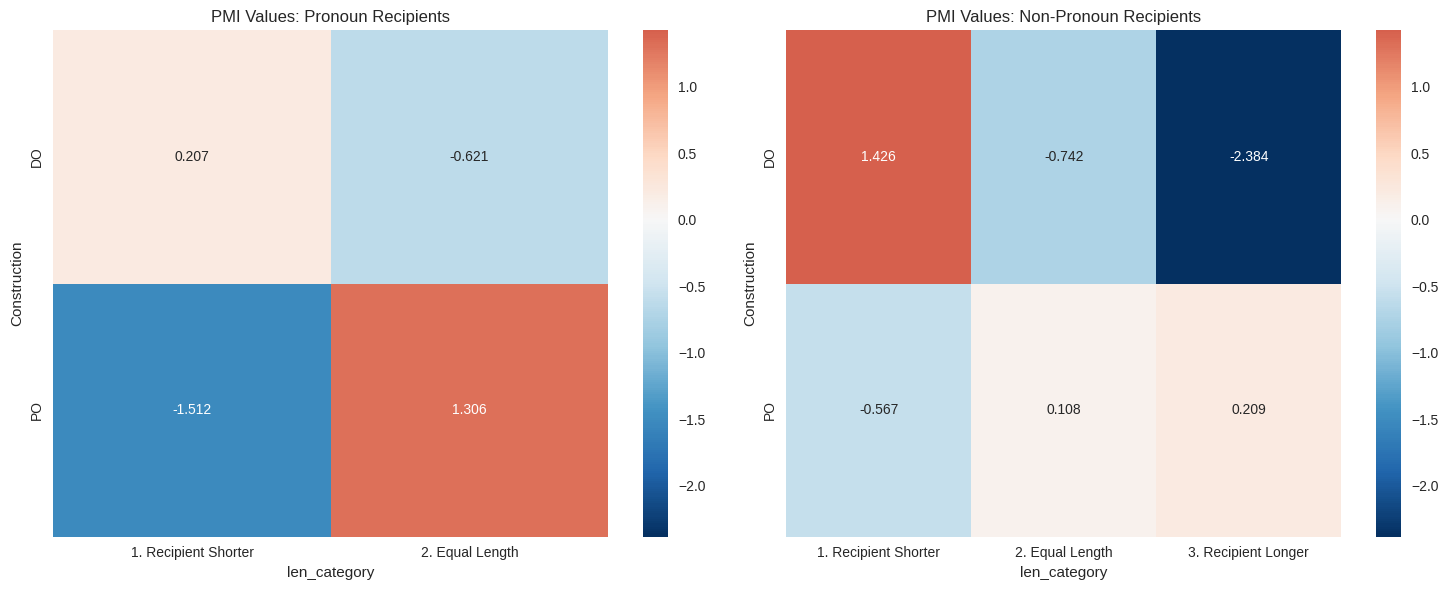

In [1]:
#cluster when sorted by length 
import pandas as pd
import os 

os.chdir('/home/qy2672/learning-alternations')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

dos_p = dos[dos['recipient_pos'] == 'PRON']
pos_p = pos[pos['recipient_pos'] == 'PRON']
dos_notp = dos[dos['recipient_pos'] != 'PRON']
pos_notp = pos[pos['recipient_pos'] != 'PRON']

def add_length_category(df):
    df = df.copy()
    df['rec_len'] = df['recipient'].str.split().str.len()
    df['theme_len'] = df['theme'].str.split().str.len()
    df['len_category'] = np.where(df['rec_len'] < df['theme_len'], '1. Recipient Shorter',
                                np.where(df['rec_len'] == df['theme_len'], '2. Equal Length',
                                        '3. Recipient Longer'))
    return df

# Process dataframes
dos_p = add_length_category(dos_p)
pos_p = add_length_category(pos_p)
dos_notp = add_length_category(dos_notp)
pos_notp = add_length_category(pos_notp)

def calculate_fit_stats(df, construction):
    # Convert length categories to numeric values for fitting
    category_map = {
        '1. Recipient Shorter': 0,
        '2. Equal Length': 1,
        '3. Recipient Longer': 2
    }
    x = df[df['Construction'] == construction]['Length Category'].map(category_map)
    y = df[df['Construction'] == construction]['Score']
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2, p_value

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

do_color = '#3498db'
po_color = '#e67e22'

plot_configs = [
    (0, 0, dos_p, pos_p, 'loose-default', 'Pronoun Recipients'),
    (0, 1, dos_p, pos_p, 'loose-balanced', 'Pronoun Recipients'),
    (1, 0, dos_notp, pos_notp, 'loose-default', 'Non-Pronoun Recipients'),
    (1, 1, dos_notp, pos_notp, 'loose-balanced', 'Non-Pronoun Recipients'),
]

for row, col, do_df, po_df, model_name, title in plot_configs:
    ax = axes[row, col]
    
    box_data = {
        'Score': np.concatenate([do_df[model_name + '_ratio'], 
                               po_df[model_name + '_ratio']]),
        'Construction': ['DO'] * len(do_df) + ['PO'] * len(po_df),
        'Length Category': np.concatenate([do_df['len_category'], 
                                        po_df['len_category']])
    }
    df_plot = pd.DataFrame(box_data)
    
    # Create box and strip plots
    sns.boxplot(data=df_plot, x='Length Category', y='Score', 
               hue='Construction', 
               palette={'DO': do_color, 'PO': po_color},
               width=0.7, showfliers=False, ax=ax)
    
    sns.stripplot(data=df_plot, x='Length Category', y='Score', 
                 hue='Construction', 
                 palette={'DO': do_color, 'PO': po_color},
                 dodge=True, size=4, alpha=0.3, ax=ax)
    for i, category in enumerate(df_plot['Length Category'].unique()):
        for j, construction in enumerate(['DO', 'PO']):
            # Get the subset of data for this category and construction
            subset = df_plot[(df_plot['Length Category'] == category) & 
                            (df_plot['Construction'] == construction)]
            count = len(subset)
            
            Q1 = subset['Score'].quantile(0.25)
            Q3 = subset['Score'].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            lower_bound = Q1 - 1.5 * IQR
            
            non_outlier_min = subset[subset['Score'] >= lower_bound]['Score'].min()
            non_outlier_max = subset[subset['Score'] >= lower_bound]['Score'].max()
            x_pos = i - 0.2 + (j * 0.4)
            y_pos = non_outlier_min - 0.2 if construction == 'DO' else non_outlier_max + 0.2
            
            # Add the count annotation
            ax.text(x_pos, y_pos, f'n={count}', 
                ha='center', va='bottom',
                color=do_color if construction == 'DO' else po_color)
    
    # Calculate and plot linear fits
    x_fit = np.array([0, 1, 2])  # Numeric values for categories
    
    # DO fit
    do_slope, do_intercept, do_r2, do_p = calculate_fit_stats(df_plot, 'DO')
    y_fit_do = do_slope * x_fit + do_intercept
    ax.plot(x_fit, y_fit_do, '--', color=do_color, linewidth=2)
    
    # PO fit
    po_slope, po_intercept, po_r2, po_p = calculate_fit_stats(df_plot, 'PO')
    y_fit_po = po_slope * x_fit + po_intercept
    ax.plot(x_fit, y_fit_po, '--', color=po_color, linewidth=2)
    
    # Add statistical annotations
    fit_stats_text = (f'DO: slope={do_slope:.3f}, R²={do_r2:.3f}\n'
                     f'PO: slope={po_slope:.3f}, R²={po_r2:.3f}')
    ax.text(0.05, 0.95, fit_stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_title(f'{model_name}\n{title}')
    ax.set_xlabel('Length Category')
    ax.set_ylabel('DO-pref Score' if col == 0 else '')
    ax.grid(True, alpha=0.2)
    ax.set_ylim(-2, 1)
    
    if col == 1:
        ax.legend(title='Construction', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend().remove()

plt.tight_layout()
plt.show()


from scipy.stats import chi2_contingency

def calculate_pmi(joint_prob, prob_x, prob_y):
    """Calculate PMI given probabilities"""
    return np.log2(joint_prob / (prob_x * prob_y))

def calculate_pmi_table(df_do, df_po):
    """Calculate PMI between construction type and length categories"""
    # Combine data
    do_data = df_do.copy()
    po_data = df_po.copy()
    do_data['Construction'] = 'DO'
    po_data['Construction'] = 'PO'
    combined = pd.concat([do_data, po_data])
    
    # Create contingency table
    contingency = pd.crosstab(combined['Construction'], 
                             combined['len_category'])
    
    # Calculate probabilities
    total = contingency.sum().sum()
    prob_construction = contingency.sum(axis=1) / total
    prob_length = contingency.sum(axis=0) / total
    
    # Calculate PMI for each cell
    pmi_values = pd.DataFrame(index=contingency.index, 
                            columns=contingency.columns)
    
    for const in contingency.index:
        for length in contingency.columns:
            joint_prob = contingency.loc[const, length] / total
            pmi_values.loc[const, length] = calculate_pmi(
                joint_prob,
                prob_construction[const],
                prob_length[length]
            )
    
    # Calculate chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    return pmi_values, chi2, p_value, contingency

# Calculate PMI for pronoun cases
pmi_pron, chi2_pron, p_pron, cont_pron = calculate_pmi_table(dos_p, pos_p)
# Calculate PMI for non-pronoun cases
pmi_nonpron, chi2_nonpron, p_nonpron, cont_nonpron = calculate_pmi_table(dos_notp, pos_notp)

# Create formatted output tables
def format_table(pmi_values, contingency, chi2, p_value, title):
    print(f"\n{title}")
    print("-" * 80)
    print("\nPMI Values:")
    print(pmi_values.round(3))
    print("\nContingency Table (Counts):")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.3f}")
    print(f"p-value: {p_value:.3e}")

# Display results
format_table(pmi_pron, cont_pron, chi2_pron, p_pron, "Pronoun Recipients")
format_table(pmi_nonpron, cont_nonpron, chi2_nonpron, p_nonpron, "Non-Pronoun Recipients")

# Visualize PMI values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot PMI heatmaps
vmin = min(pmi_pron.values.min(), pmi_nonpron.values.min())
vmax = max(pmi_pron.values.max(), pmi_nonpron.values.max())

sns.heatmap(pmi_pron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('PMI Values: Pronoun Recipients')

sns.heatmap(pmi_nonpron.astype(float), annot=True, fmt='.3f', 
            cmap='RdBu_r', center=0, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('PMI Values: Non-Pronoun Recipients')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm

def prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, model_name):
    # Combine DO data
    dos_all = pd.concat([dos_p, dos_notp])
    dos_all['Construction'] = 'DO'
    
    # Combine PO data
    pos_all = pd.concat([pos_p, pos_notp])
    pos_all['Construction'] = 'PO'
    
    # Combine all data
    all_data = pd.concat([dos_all, pos_all])
    
    # Create continuous length variables
    all_data['recipient_length'] = all_data['recipient'].apply(
        lambda x: len([word for word in x.split() if any(char.isalnum() for char in word)])
    )    
    all_data['theme_length'] = all_data['theme'].apply(
        lambda x: len([word for word in x.split() if any(char.isalnum() for char in word)])
    ) 
    all_data['length_difference'] = np.log(all_data['recipient_length'] / all_data['theme_length'])
    
    # Create pronoun indicator
    all_data['recipient_pronoun'] = np.where(all_data['recipient_pos'] == 'PRON', 0.5, -0.5)
    all_data['theme_pronoun'] = np.where(all_data['theme_pos'] == 'PRON', 0.5, -0.5)
    
    # Get scores from specified model
    all_data['score'] = all_data[f'{model_name}_ratio']
    all_data['is_balanced'] = 0.5 if model_name == 'babylm-balanced' else -0.5    
    return all_data


# Prepare and combine the data
data_default = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'babylm-default')
data_balanced = prepare_data_for_mixed_model(dos_p, pos_p, dos_notp, pos_notp, 'babylm-balanced')
model_data = pd.concat([data_default, data_balanced])
# model_data = model_data[['recipient_length', 'theme_length', 'length_difference', 'recipient_pronoun', 'theme_pronoun', 'score', 'is_balanced', 'verb_lemma']]
model_data.to_csv('experiments/model_data_full.csv', index=False)

# Create interaction terms
model_data['pronoun_balance'] = model_data['is_pronoun'] * model_data['is_balanced']  # Balance × Pronoun interaction
model_data['balanced_length'] = model_data['is_balanced'] * model_data['length_difference']  # Balance × Length interaction


# Full model design matrix (includes all terms)
X_full = sm.add_constant(model_data[[
    'is_pronoun',           # Main effect of pronoun
    'length_difference',    # Main effect of length
    'is_balanced',          # Main effect of balance
    'pronoun_balance',      # Interaction: Balance × Pronoun
    'balanced_length'       # Interaction: Balance × Length
]])

mixed_model_full = MixedLM(
    endog=model_data['score'],
    exog=X_full,
    groups=model_data['verb_lemma'],
    missing='drop'
)
results_full = mixed_model_full.fit()

X_reduced_balance_pronoun = sm.add_constant(model_data[[
    'is_pronoun',
    'length_difference',
    'is_balanced',
    'balanced_length'  # Keep Balance × Length interaction
]])

X_reduced_balance_length = sm.add_constant(model_data[[
    'is_pronoun',
    'length_difference',
    'is_balanced',
    'pronoun_balance'  # Keep Balance × Pronoun interaction
]])

X_reduced_both = sm.add_constant(model_data[[
    'is_pronoun',
    'length_difference',
    'is_balanced'
]])

# Fit full model
mixed_model_full = MixedLM(
    endog=model_data['score'],
    exog=X_full,
    groups=model_data['verb_lemma'],
    missing='drop'
)
results_full = mixed_model_full.fit()

# Fit reduced models
mixed_model_reduced_balance_pronoun = MixedLM(
    endog=model_data['score'],
    exog=X_reduced_balance_pronoun,
    groups=model_data['verb_lemma'],
    missing='drop'
)
results_reduced_balance_pronoun = mixed_model_reduced_balance_pronoun.fit()

mixed_model_reduced_balance_length = MixedLM(
    endog=model_data['score'],
    exog=X_reduced_balance_length,
    groups=model_data['verb_lemma'],
    missing='drop'
)
results_reduced_balance_length = mixed_model_reduced_balance_length.fit()

mixed_model_reduced_both = MixedLM(
    endog=model_data['score'],
    exog=X_reduced_both,
    groups=model_data['verb_lemma'],
    missing='drop'
)
results_reduced_both = mixed_model_reduced_both.fit()

# Perform likelihood ratio tests
from scipy.stats import chi2

def lr_test(full, reduced):
    lr_stat = -2 * (reduced.llf - full.llf)
    df = len(full.params) - len(reduced.params)
    p_value = chi2.sf(lr_stat, df)
    return lr_stat, df, p_value

# Test Balance × Pronoun interaction
lr_bp, df_bp, p_bp = lr_test(results_full, results_reduced_balance_pronoun)
print(f"Balance × Pronoun Interaction: χ²({df_bp}) = {lr_bp:.2f}, p = {p_bp:.4f}")

# Test Balance × Length interaction
lr_bl, df_bl, p_bl = lr_test(results_full, results_reduced_balance_length)
print(f"Balance × Length Interaction: χ²({df_bl}) = {lr_bl:.2f}, p = {p_bl:.4f}")

# Test both interactions jointly
lr_both, df_both, p_both = lr_test(results_full, results_reduced_both)
print(f"Both Interactions Jointly: χ²({df_both}) = {lr_both:.2f}, p = {p_both:.4f}")

KeyError: 'is_pronoun'